# 네이버 영화 리뷰 텍스트 감성분석 하기

이전에 영문 텍스트에 대한 감정 분석을 진행해보았습니다. 이번에는 한국어 텍스트의 감성 분석을 진행해봅시다!

먼저 아래 커맨드로 파일을 다운로드 받은 후 `./data` 디렉토리로 옮겨줍시다.

```bash
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
```



## 데이터 준비와 확인

In [1]:
# 필요한 모듈 Import
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
# 데이터를 불러옵시다.
import os
data_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/'
train_data = pd.read_table(data_path + 'ratings_train.txt')
test_data = pd.read_table(data_path + 'ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 데이터 로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 되어있습니다. 이것을 읽어 자신만의 방법으로 imdb.data_loader()와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작한다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 (Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 맅ㄴ



In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()

stopwords = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stopwords = stopwords.split(' ')
# 스탑워드를 띄어쓰기로 구분한 뒤 스플릿으로...(하나하나 따옴표 쳐주기엔 귀찮고 너무 많다.)
# 스탑워드 출처는 https://mr-doosun.tistory.com/24
# 불용어에 대한 블로그 글 https://wikidocs.net/22530
# 그런데 은는이가를 스탑워드로 넣어봐야 실제로 ~은 ~는 ~이 에서 조사가 삭제되지는 않는데... 굳이 저렇게 해야하나....?
# 이런 식의 불용어 처리는 문제가 많을 것 같다. 금, 은, 동 에서 은만 빠져버릴 거고...음... 암튼 그렇게 이상한 문장이 많이 만들어질 것 같은데...

def load_data(train_data, test_data, num_words = 30000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print(len(word_to_index))

훈련 샘플 개수: 146182, 테스트 개수: 49157
10000


In [4]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  13.056184376903742
문장 길이의 최대 :  115
문장 길이 표준 편차 :  10.354632639194008
pad_sequences maxlen :  54
전체 문장의 0.9965239916248163%가 maxlen 설정값 이내에 포함됩니다.


### 적절한 최대 문장 길이 지정 & `keras.preprocessing.sequence.pad_sequences`을 활용한 패딩 추가



In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
print(x_train.shape)

(146182, 54)


## 모델 구성 및 validation set 구성

In [8]:
vocab_size = 30000 # 어휘 사전의 크기
word_vector_dim = 15 # 워드 벡터의 차원수

In [9]:
# 모델 설계. 위에서 만든 모델을 사용해봅시다.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          450000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### validation set 분리

In [10]:
# validation set 10000건 분리
x_val = x_train[:20000]
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = x_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 54)
(126182,)


## 모델 훈련 개시

In [11]:
def 훈련과결과():
    model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

    epochs = 15
# 함수 안에 넣었기에 글로발 써줘야 밖에서도 써먹을 수 있다
    global history
    history = model.fit(partial_x_train, partial_y_train,
                        epochs = epochs, batch_size = 512,
                        validation_data = (x_val, y_val),
                        verbose = 1)
    results = model.evaluate(x_test, y_test, verbose = 2)
    print(results)
    global history_dict
    history_dict = history.history
    print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
    # 밖에다 빼면 똑같은 그래프만 그린다. 히스토리딕을 다시 설정해줘야함!
    
훈련과결과()

Epoch 1/15
247/247 [==============================] - 9s 20ms/step - loss: 0.6352 - accuracy: 0.6084 - val_loss: 0.3777 - val_accuracy: 0.8320
Epoch 2/15
247/247 [==============================] - 2s 9ms/step - loss: 0.3564 - accuracy: 0.8467 - val_loss: 0.3628 - val_accuracy: 0.8418
Epoch 3/15
247/247 [==============================] - 2s 9ms/step - loss: 0.3215 - accuracy: 0.8631 - val_loss: 0.3616 - val_accuracy: 0.8418
Epoch 4/15
247/247 [==============================] - 2s 9ms/step - loss: 0.3040 - accuracy: 0.8723 - val_loss: 0.3655 - val_accuracy: 0.8406
Epoch 5/15
247/247 [==============================] - 2s 9ms/step - loss: 0.2808 - accuracy: 0.8855 - val_loss: 0.3701 - val_accuracy: 0.8396
Epoch 6/15
247/247 [==============================] - 2s 9ms/step - loss: 0.2626 - accuracy: 0.8949 - val_loss: 0.3855 - val_accuracy: 0.8364
Epoch 7/15
247/247 [==============================] - 2s 9ms/step - loss: 0.2400 - accuracy: 0.9060 - val_loss: 0.4031 - val_accuracy: 0.8339
Epoch

## Loss, Accuracy 그래프 시각화

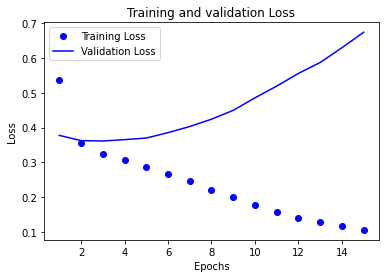

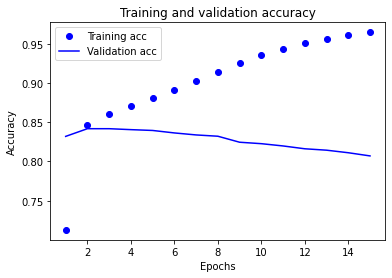

In [12]:
import matplotlib.pyplot as plt
def 그림():
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.clf()

    plt.plot(epochs, loss, 'bo', label = "Training Loss")
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title("Training and validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf() # 그림 초기화

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

그림()

In [13]:
# LSTM 레이어로 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM state 벡터의 차원수 (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          450000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 768       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 450,849
Trainable params: 450,849
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
247/247 [==============================] - 6s 15ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6118 - val_accuracy: 0.7221
Epoch 2/15
247/247 [==============================] - 3s 13ms/step - loss: 0.4780 - accuracy: 0.7962 - val_loss: 0.3716 - val_accuracy: 0.8345
Epoch 3/15
247/247 [==============================] - 3s 13ms/step - loss: 0.3457 - accuracy: 0.8505 - val_loss: 0.3624 - val_accuracy: 0.8393
Epoch 4/15
247/247 [==============================] - 3s 13ms/step - loss: 0.3280 - accuracy: 0.8605 - val_loss: 0.3675 - val_accuracy: 0.8385
Epoch 5/15
247/247 [==============================] - 3s 13ms/step - loss: 0.3140 - accuracy: 0.8660 - val_loss: 0.3719 - val_accuracy: 0.8370
Epoch 6/15
247/247 [==============================] - 3s 13ms/step - loss: 0.3130 - accuracy: 0.8657 - val_loss: 0.3747 - val_accuracy: 0.8355
Epoch 7/15
247/247 [==============================] - 3s 13ms/step - loss: 0.3093 - accuracy: 0.8677 - val_loss: 0.3697 - val_accuracy: 0.8367

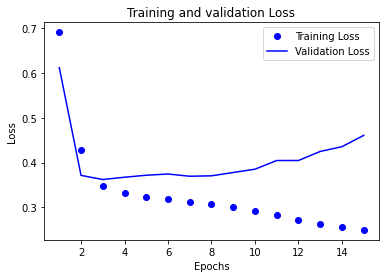

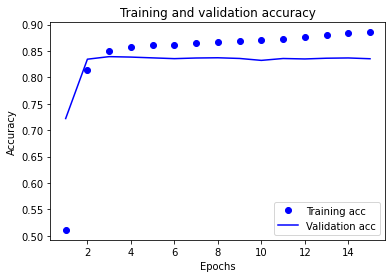

In [14]:
훈련과결과()
그림()

In [15]:
# GlobalMaxPooling1D() 레이어 하나만 사용
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 15)          450000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 450,137
Trainable params: 450,137
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
247/247 [==============================] - 2s 6ms/step - loss: 0.6638 - accuracy: 0.6660 - val_loss: 0.4430 - val_accuracy: 0.8140
Epoch 2/15
247/247 [==============================] - 1s 6ms/step - loss: 0.4061 - accuracy: 0.8296 - val_loss: 0.3732 - val_accuracy: 0.8324
Epoch 3/15
247/247 [==============================] - 1s 6ms/step - loss: 0.3400 - accuracy: 0.8572 - val_loss: 0.3648 - val_accuracy: 0.8364
Epoch 4/15
247/247 [==============================] - 1s 6ms/step - loss: 0.3140 - accuracy: 0.8690 - val_loss: 0.3659 - val_accuracy: 0.8373
Epoch 5/15
247/247 [==============================] - 1s 6ms/step - loss: 0.2912 - accuracy: 0.8810 - val_loss: 0.3699 - val_accuracy: 0.8389
Epoch 6/15
247/247 [==============================] - 1s 6ms/step - loss: 0.2751 - accuracy: 0.8884 - val_loss: 0.3773 - val_accuracy: 0.8370
Epoch 7/15
247/247 [==============================] - 1s 6ms/step - loss: 0.2659 - accuracy: 0.8927 - val_loss: 0.3870 - val_accuracy: 0.8370
Epoch 

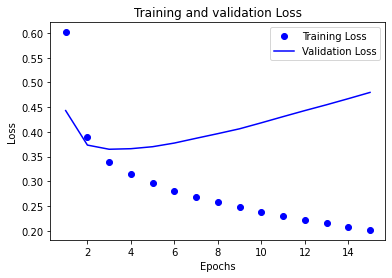

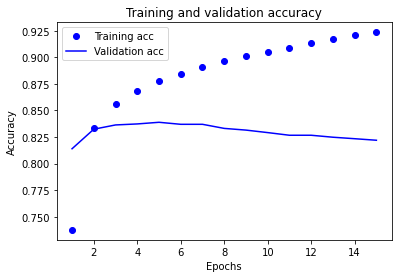

In [16]:
훈련과결과()
그림()

# 분석

공통적으로 최초 벨리데이션 정확도는 높은데 학습이 원활하진 않는다. 에폭이 3만 넘어도 옵버피팅이 나타나는 것 처럼 벨리데이션에 대한 정확도가 팍팍 깎여나간다.

## 한국어 Word2Vec 임베딩을 활용하여 성능 개선

한국어 Word2Vec은 아래 링크에서 구할 수 있습니다.

- 박규병님이 만드신 한국어 Word2Vec 모델 : <https://github.com/Kyubyong/wordvectors>
- 위의 내용을 직접 다운로드 할 수 있는 링크 : <https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view>

In [17]:
import gensim
from gensim.models import word2vec

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [18]:
# 파이썬 2 기반으로 쓰였대서 클라우드 쉘에서 파이썬2로도 열어봤지만 안되네요...
# 3로 열어도 뭔가 오류가 뜨고..
#이거저거 다 해봐도 그때마다 새로운 오류가 뜹니다....ㅠㅠ

# coding: utf-8
#!/usr/bin/python2
import argparse
import codecs
import lxml.etree as ET
import os
import regex

# arguments setting 
parser = argparse.ArgumentParser()
parser.add_argument('--lcode', help='ISO 639-1 code of target language. See `lcodes.txt`.')
parser.add_argument('--max_corpus_size', type=int, default=1000000000, help='the maximum size of the corpus. Feel free to adjust it according to your computing power.')
args = parser.parse_args()

lcode = args.lcode
if lcode == 'ko':
    from konlpy.tag import Kkma # pip install konlpy. See http://konlpy.org/en/v0.4.4/ for further information.
    kkma = Kkma()
    print ("kkma succesfuly loaded!")
elif lcode == 'ja':
    import MeCab # See https://pypi.python.org/pypi/mecab-python/0.996
    mecab = MeCab.Tagger("-Owakati")
    print ("mecab succesfuly loaded!")
elif lcode == 'zh':
    import jieba # See https://pypi.python.org/pypi/jieba/
    print ("jieba succesfuly loaded!")
elif lcode == 'vi':
    from pyvi.pyvi import ViTokenizer # See https://pypi.python.org/pypi/pyvi
    print ("pyvi succesfuly loaded!")
elif lcode == 'th':  
    import pythai # See https://pypi.python.org/pypi/pythai  
    print ("pythai succesfuly loaded!")
# elif lcode == 'ar':
#     os.environ['CLASSPATH'] = "../stanford-segmenter-2015-12-09"
#     from nltk.tokenize.stanford_segmenter import StanfordSegmenter
#     segmenter = StanfordSegmenter(path_to_jar="../stanford-segmenter-2015-12-09/stanford-segmenter-3.6.0.jar", 
#                                path_to_sihan_corpora_dict="../stanford-segmenter-2015-12-09/data", 
#                                path_to_model="../stanford-segmenter-2015-12-09/data/pku.gz", 
#                                path_to_dict="../stanford-segmenter-2015-12-09/data/dict-chris6.ser.gz")
#     print "StanfordSegmenter succesfuly loaded!"
    
max_corpus_size = args.max_corpus_size
fname = "{}wiki-20161201-pages-articles-multistream.xml".format(lcode)    

def clean_text(text):
    global lcode
    
    # Common
    text = regex.sub("(?s)<ref>.+?</ref>", "", text) # remove reference links
    text = regex.sub("(?s)<[^>]+>", "", text) # remove html tags
    text = regex.sub("&[a-z]+;", "", text) # remove html entities
    text = regex.sub("(?s){{.+?}}", "", text) # remove markup tags
    text = regex.sub("(?s){.+?}", "", text) # remove markup tags
    text = regex.sub("(?s)\[\[([^]]+\|)", "", text) # remove link target strings
    text = regex.sub("(?s)\[\[([^]]+\:.+?]])", "", text) # remove media links
    
    text = regex.sub("[']{5}", "", text) # remove italic+bold symbols
    text = regex.sub("[']{3}", "", text) # remove bold symbols
    text = regex.sub("[']{2}", "", text) # remove italic symbols
    
    if lcode in ['ko']: # korean
        text = regex.sub(u"[^ \r\n\p{Hangul}.?!]", " ", text) # Replace unacceptable characters with a space.
    elif lcode in ['ja']: # japanese
        text = regex.sub(u"[^\r\n\p{Han}\p{Hiragana}\p{Katakana}ー。！？]", "", text)
    elif lcode in ['zh']: # chinsese
        text = regex.sub(u"[^\r\n\p{Han}。！？]", "", text)
    elif lcode in ['th']: # thai
        text = regex.sub(u"[^ \r\n\p{Thai}.?!]", " ", text)
    elif lcode in ['ru']: # russian
        text = regex.sub(u"[^ \r\n\p{Cyrillic}.?!\-]", " ", text)
        text = text.lower()
#     elif lcode in ['ar']: # arabic
#         text = regex.sub(u"[^ \r\n\p{Arabic}.?!\-]", " ", text)
    elif lcode in ['hi']: # hindi
        text = regex.sub(u"[^ \r\n\p{Devanagari}.।?!\-]", " ", text)
    elif lcode in ['bn']: # bengali
        text = regex.sub(u"[^ \r\n\p{Bengali}.।?!\-]", " ", text)
    elif lcode in ['de']: # german
        text = regex.sub(u"[^ \r\n\p{Latin}\-'‘’.?!]", " ", text)
    else: # Mostly european languages
        text = regex.sub(u"[^ \r\n\p{Latin}\-'‘’.?!]", " ", text)
        text = text.lower()
    
    # Common
    text = regex.sub("[ ]{2,}", " ", text) # Squeeze spaces.
    return text

def sentence_segment(text):
    '''
    Args:
      text: A string. A unsegmented paragraph.
    
    Returns:
      A list of sentences.
    '''
    global lcode
    if lcode in ['ja', 'zh']:
        sents = regex.split(u"([。！？])?[\n]+|[。！？]", text) 
    elif lcode in ['th']:
        sents = text.split("[\n]+") 
    elif lcode in ['hi', 'bn']: # hindi, bengali
        sents = regex.split(u"([.।?!])?[\n]+|[.।?!] ", text)
    elif lcode in ['de']: # german
        sents = regex.split("([.?!])?[\n]+|[.?!] ", text)
        sents = [sent[0].lower() + sent[1:] for sent in sents if sent is not None and len(sent) > 1]
    else:
        sents = regex.split("([.?!])?[\n]+|[.?!] ", text)
    return sents
        
def word_segment(sent):
    '''
    Args:
      sent: A string. A sentence.
    
    Returns:
      A list of words.
    '''
    global lcode
    if lcode in ['ko']:
        words = [word for word, _ in kkma.pos(sent)]
    elif lcode in ['ja']:
        words = mecab.parse(sent.encode('utf8')).split() 
    elif lcode in ['th']:
        words = pythai.split(sent)
    elif lcode in ['vi']:
        words = ViTokenizer.tokenize(sent).split()        
    elif lcode in ['zh']:
        words = list(jieba.cut(sent, cut_all=False)) 
#     elif lcode in ['ar']:
#         words = segmenter.segment(sent).split()
    else: # Mostly european languages
        words = sent.split()
    
    return words

def build_corpus():
    global lcode, max_corpus_size, fname
    with codecs.open("data/{}.txt".format(lcode), 'w', 'utf-8') as fout:
        i = 1
        j = 1
        ns = "{http://www.mediawiki.org/xml/export-0.10/}" # namespace
        for _, elem in ET.iterparse("data/{}".format(fname), tag=ns+"text"):
            running_text = elem.text
            try:
                running_text = clean_text(running_text)
                sents = sentence_segment(running_text)
                for sent in sents:
                    if sent is not None:
                        words = word_segment(sent)
                        if len(words) > 10:
                            if lcode in ['ja']:
                                fout.write(" ".join(words).decode('utf8') + "\n")
                            else:
                                fout.write(" ".join(words) + "\n")
                                
            except:
                continue # it's okay as we have a pretty big corpus!
            elem.clear() # We need to save memory!
            if i % 1000 == 0: 
                print (i,)
                fsize = os.path.getsize("data/{}.txt".format(lcode))
                if fsize > max_corpus_size:
                    break
            i += 1

if __name__ == "__main__":
    build_corpus()
    
    print ("Done")
    
# 아무리 해도 에러가 계속 나서...ㅠㅠ
# SyntaxError: Missing parentheses in call to 'print'. Did you mean print("kkma succesfuly loaded!")?
# print 에 괄호가 빠져있다고 하니 이렇게 괄호를 넣어주시면 해결됩니다.
# 출처: https://korbillgates.tistory.com/93 [생물정보학자의 블로그]

usage: ipykernel_launcher.py [-h] [--lcode LCODE]
                             [--max_corpus_size MAX_CORPUS_SIZE]
ipykernel_launcher.py: error: unrecognized arguments: -f /aiffel/.local/share/jupyter/runtime/kernel-8b3949ab-02b2-4616-a5ac-af26bf21394d.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
